In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [24]:
import numpy as np
import math

def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            exponent = -(x ** 2 + y ** 2) / (2 * sigma ** 2)
            kernel[i, j] = math.exp(exponent) / (2 * math.pi * sigma ** 2)

    kernel /= np.sum(kernel)
    return kernel

def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

# Example usage
def make_noise():
    kernel_size = 1024
    sigma = 155
    noisy = np.zeros((512,512))
    noisy2 = np.zeros((512,512))
    gaussian = gaussian_kernel(kernel_size, sigma)
    gaussian2 = gaussian_kernel(512, 80)
    mx,my = gaussian.shape
    mx = int(mx/2)-30
    my = int(my/2)-30
    mx2,my2 = gaussian2.shape
    mx2 = int(mx2/2)-10
    my2 = int(my2/2)-10
    for i in range(512):
        for j in range(512):
            noisy[512-i-1][512-j-1] = gaussian[mx+i][my+j]
            
    for i in range(256):
        for j in range(256):
            noisy2[i][j] = gaussian2[mx2+i][my2+j]

    return normalize_image(normalize_image(noisy)+normalize_image(noisy2)) #make pdf function of illuminated img between 0-1 after normalization and then return it
    


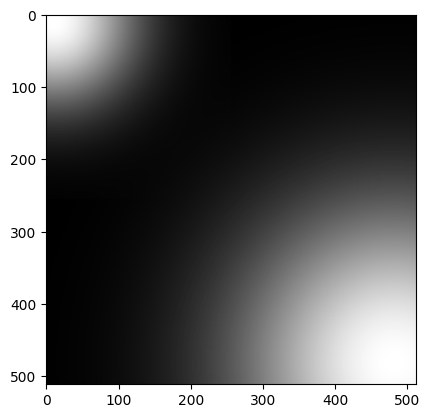

In [25]:
illuminated_image = make_noise() 
illuminated_image = illuminated_image*255
plt.imshow(illuminated_image,cmap='gray')

In [26]:
image = cv2.imread(r"C:\Users\WIN\Desktop\image_lab\Lena.jpg")
im=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

Text(0.5, 1.0, 'Corrupted image')

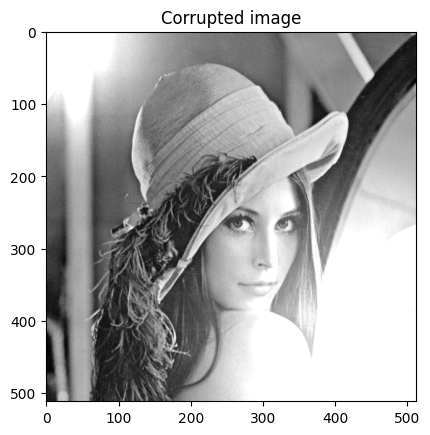

In [27]:

#corrupted_image = normalize_image(im + illuminated_image)*255
corrupted_image = (im + illuminated_image)
scaled_image = np.interp(corrupted_image, (0, 255), (0, 512))
corrupted_image = scaled_image.astype(np.uint16)
#print(corrupted_image)
plt.imshow(corrupted_image,cmap='gray')
plt.title("Corrupted image")

# Apply homomorphic filtering

In [28]:
# import numpy as np
# import cv2

# # Homomorphic filter
# def butterworth_filter(I_shape, filter_params):
#     P = I_shape[0]/2
#     Q = I_shape[1]/2
#     U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
#     Duv = (((U-P)**2+(V-Q)**2)).astype(float)
#     H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
#     return (1 - H)

# # Methods
# def apply_filter(a,b, I, H):
#     H = np.fft.fftshift(H)
#     I_filtered = (a + b*H)*I
#     return I_filtered

# def Homofilter(a,b, I, filter_params):

#     H = None
    
#     #STEP 1: Take the image to log domain and then to frequency domain 
#     I_log = np.log1p(np.array(I, dtype="float"))
    
#     #STEP 2: Make the fourier transform of it
#     I_fft = np.fft.fft2(I_log)
    
#     #STEP 3: Create and Apply filter on frequency domain then take the image back to spatial domain
#     H = butterworth_filter(I_fft.shape, filter_params)   
#     I_fft_filt = apply_filter(a,b,I_fft,H)
    
#     #STEP 4: Make inverse fourier transform
#     I_filt = np.fft.ifft2(I_fft_filt)
    
#     #STEP 5: Make exponential of the inverse ft
#     I = np.exp(np.real(I_filt))-1
    
#     return np.uint8(I)

# img = corrupted_image
# img_filtered = Homofilter(.7,1.8,img, filter_params=[30,2])

# fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
# axes[0,0].set_title('input image')
# axes[0,0].imshow(im,cmap='gray')
# axes[0,1].set_title('illumination')
# axes[0,1].imshow(illuminated_image,cmap='gray')
# axes[1,0].set_title('corrupted image')
# axes[1,0].imshow(img,cmap='gray')
# axes[1,1].set_title('filtered image')
# axes[1,1].imshow(img_filtered,cmap='gray')



# fig.subplots_adjust(wspace=0.3)
    

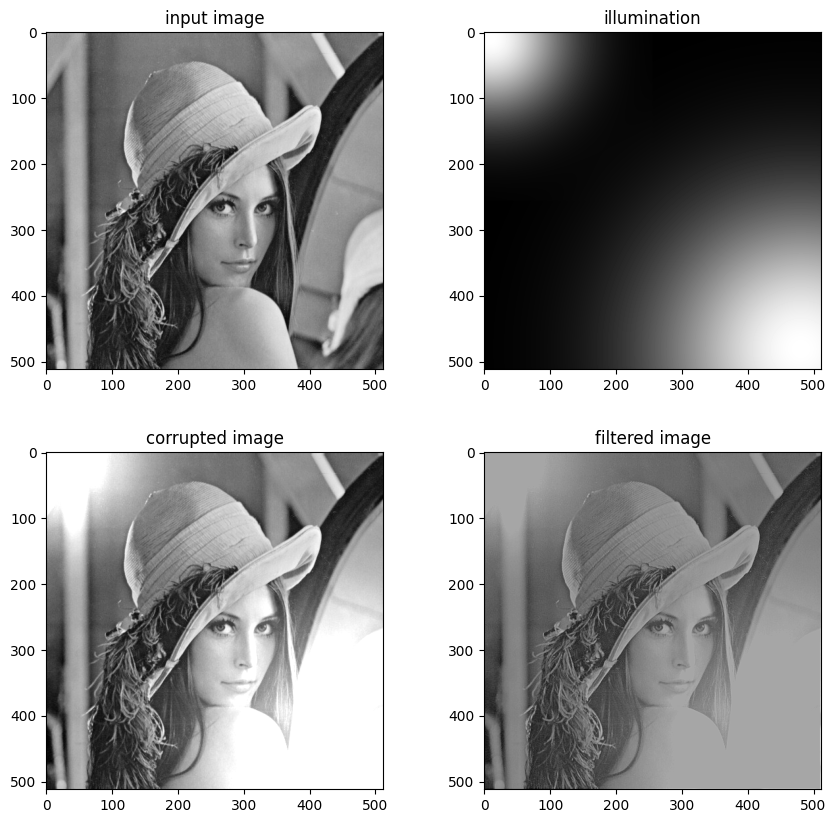

In [29]:
import numpy as np
import cv2

def Create_filter(img):
    
    img_h, img_w = img.shape
    homo_filter = np.zeros((img_h, img_w), dtype=np.float32)

    gh = 1.2
    gl = 0.5
    c = 0.1
    d0 = 50

    center_i, center_j = img_h // 2, img_w // 2

    for i in range(img_h):
        for j in range(img_w):
            duv = (i-center_i)**2 + (j-center_j)**2
            homo_filter[i, j] = (gh-gl) * (1-np.exp(-c * (duv / d0**2))) + gl
            
    return homo_filter


def Apply_Filter(image, homo_filter):
    
    log_im = np.log1p(image) 
    mag_spectrum=np.fft.fft2(log_im)
    mag_spectrum_shifted = np.fft.fftshift(mag_spectrum)
    
    filtered_spectrum_shifted = mag_spectrum_shifted * homo_filter
    
    filtered_spectrum_inv = np.fft.ifftshift(filtered_spectrum_shifted)
    filtered_image = np.fft.ifft2(filtered_spectrum_inv)

    
    exp_image = np.exp(np.real(filtered_image))

    
    filtered_im_norm = cv2.normalize(exp_image, None, 0, 255, cv2.NORM_MINMAX)

    
    filtered_image = filtered_im_norm.astype(np.uint8)

    return filtered_image


img=corrupted_image
homo_filter=Create_filter(img)
img_filtered = Apply_Filter(img, homo_filter)

##extra image for better result visualization
i = cv2.imread(r"C:\Users\WIN\Downloads\homo.jpg",0)
i = cv2.resize(i,(512,512))
hf = Create_filter(i)
i_f = Apply_Filter(i,hf)
#ended......

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
axes[0,0].set_title('input image')
axes[0,0].imshow(im,cmap='gray')
axes[0,1].set_title('illumination')
axes[0,1].imshow(illuminated_image,cmap='gray')
axes[1,0].set_title('corrupted image')
axes[1,0].imshow(img,cmap='gray')
axes[1,1].set_title('filtered image')
axes[1,1].imshow(img_filtered,cmap='gray')

fig.subplots_adjust(wspace=0.3)



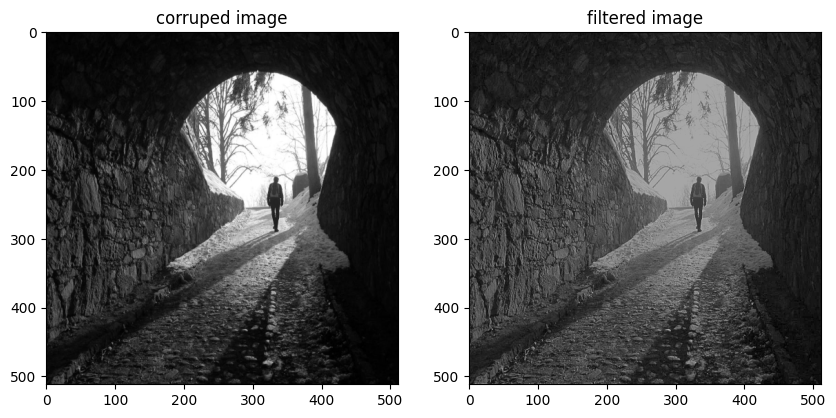

In [30]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.set_title('corruped image')
ax1.imshow(i,cmap='gray')
ax2.set_title('filtered image')
ax2.imshow(i_f,cmap='gray')